In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mcap_ros2.reader import read_ros2_messages
import sys


# 获取当前 notebook 所在的目录
current_dir = os.getcwd()

# 获取项目根目录 (即当前目录的上一级)
project_root = os.path.abspath(os.path.join(current_dir, ".."))

# 将根目录加入到 Python 的搜索路径中
if project_root not in sys.path:
    sys.path.append(project_root)


from typing import Optional
from core.utils.common import error, info
from core.utils import radardsp as rdsp


from core.config import EL_CFAR_SKIP_BIN, NUMBER_RANGE_BINS_MIN
from core.config import NUMBER_DOPPLER_BINS_MIN
from core.config import NUMBER_AZIMUTH_BINS_MIN
from core.config import NUMBER_ELEVATION_BINS_MIN
from core.config import DOA_METHOD
from core.config import RDSP_METHOD

from core.config import RD_OS_CFAR_WS
from core.config import RD_OS_CFAR_GS
from core.config import RD_OS_CFAR_K
from core.config import RD_OS_CFAR_TOS

from core.config import AZ_OS_CFAR_WS
from core.config import AZ_OS_CFAR_GS
from core.config import AZ_OS_CFAR_TOS

# capon parameters
# from core.config import CAPON_METHOD
from core.config import AZ_BINS, EL_BINS, ANGLE_RES_EL, ANGLE_RES_AZ, AZ_RANGE, EL_RANGE,AZ_MESH, EL_MESH

from core.config import RA_OS_CFAR_WS
from core.config import RA_OS_CFAR_GS
from core.config import RA_OS_CFAR_K
from core.config import RA_OS_CFAR_TOS

from core.config import EL_OS_CFAR_WS
from core.config import EL_OS_CFAR_GS
from core.config import EL_OS_CFAR_TOS

# CFAR skip bin
from core.config import CFAR_SKIP_RANGE_BIN_NEAR, CFAR_SKIP_RANGE_BIN_FAR, CFAR_SKIP_AZIMUTH_BIN


import core.dsp as dsp
# Azimuth angle range
AZIMUTH_FOV: float = np.deg2rad(180)
# Elevation angle range
ELEVATION_FOV: float = np.deg2rad(20)

radar_messages = []
radar_timestamps = []
sample_mcap = '/home/zcy/project/DBE-Radar/dataset/my_experiment_data/single_chip/adc_samples/data/2025_12_09_drone_mmwave_1_1_0.mcap_0.mcap'

# read_ros2_messages 返回的是一个生成器(generator)，不能直接调用 .data
# 需要遍历它来获取消息
# topics 参数通常接受一个列表
for mcap_msg in read_ros2_messages(str(sample_mcap), topics=["/radar_0/raw_data"]):
    radar_messages.append(mcap_msg.ros_msg)
    radar_timestamps.append(mcap_msg.log_time_ns)

print(f"Successfully loaded {len(radar_messages)} messages.")

if len(radar_messages) > 0:
    # 验证第一帧数据
    print(f"First message data type: {type(radar_messages[0])}")
    # 如果你想看数据，应该看列表中的第一个元素
    # print(radar_messages[0].data)
else:
    print("Warning: No messages found for topic '/radar_0/raw_data'")

In [ ]:
def get_coupling_matrix(path: str) -> np.ndarray:
    """Get the coupling matrix for calibration.

    Return:
        The coupling matrix with shape of
        (coupling_num_tx, coupling_num_rx, num_samples_per_chirp)
    """

    with open(path, "r") as fh:
        for line in fh:
            if line.startswith("# "):
                continue
            else:
                chunks = line.strip().split(" ")
                if chunks[0] == "num_tx":
                    coupling_num_tx = int(chunks[1])
                elif chunks[0] == "num_rx":
                    coupling_num_rx = int(chunks[1])
                elif chunks[0] == "data":
                    coupling_data = np.array(
                        [float(val) for val in chunks[1:]],
                        dtype=np.float32,
                    )
    return coupling_num_tx, coupling_num_rx, coupling_data
def get_antenna_layout(path: str) -> tuple[np.ndarray, np.ndarray, float]:
    rxl = []
    txl = []
    with open(path, "r") as fh:
        for line in fh:
            if line.startswith("# "):
                continue
            else:
                chunks = line.strip().split(" ")
                if chunks[0] == "rx":
                    rxl.append([int(x) for x in chunks[1:]])
                elif chunks[0] == "tx":
                    txl.append([int(x) for x in chunks[1:]])
                elif chunks[0] == "F_design":
                    F_design = float(chunks[1])
    return np.array(rxl), np.array(txl), F_design



# polar: bool = False, show: bool = True, method: str = "Capon"
#     ) -> None:
"""
    Process the raw ADC samples and render the 2D Range-Azimuth map.
    following the pipeline:
        1. Calibrate the raw ADC samples
        2. Apply the Range FFT processing +  beamforming method
        3. Render the 2D Range-Azimuth map

    Arguments:
        method: Beamforming method to use. Default is Capon
"""

def dc_remove(data: np.array) -> np.array:
    """Handle the calibration of raw ADC samples.

    Return:
        Remove DC bias of the radar sensor

    NOTE: Only the casacde chip radar sensor has the frequency and phase
    calibration
    """
    if data is None:
        exit(1)
    adc_samples = data

    # Remove DC bias
    # adc_samples -= np.mean(adc_samples)
    adc_samples_sc = adc_samples
    dc3_sc = np.mean(adc_samples_sc, axis=3)
    adc_samples = adc_samples_sc - dc3_sc[:,:,:,np.newaxis]

    return adc_samples


def get_fft_size(ne: Optional[int], na: Optional[int],
             nc: Optional[int], ns: Optional[int]) -> tuple[int, int, int, int]:
        """Get optimal FFT size.

        Arguments:
            ne: Size of the elevation axis of the data cube
            na: Size of the azimuth axis of the data cube
            nc: Number of chirp loops
            ns: Number of samples per chirp

        Return:
            Tuple of the optimal size of each parameter provided in argument
            in the exact same order.
        """
        # Estimated size of the elevation and azimuth
        if ne is not None:
            ne = rdsp.fft_size(ne)
            ne = (
                ne if ne > NUMBER_ELEVATION_BINS_MIN else NUMBER_ELEVATION_BINS_MIN
            )

        if na is not None:
            na = rdsp.fft_size(na)
            na = na if na > NUMBER_AZIMUTH_BINS_MIN else NUMBER_AZIMUTH_BINS_MIN

        if nc is not None:
            # Size of doppler FFT
            nc = rdsp.fft_size(nc)
            nc = nc if nc > NUMBER_DOPPLER_BINS_MIN else NUMBER_DOPPLER_BINS_MIN
        if ns is not None:
            # Size of range FFT
            ns = rdsp.fft_size(ns)
            ns = ns if ns > NUMBER_RANGE_BINS_MIN else NUMBER_RANGE_BINS_MIN

        return ne, na, nc, ns




def pre_process(adc_samples: np.array, apply_padding: bool = True) -> tuple[np.array, np.array]:
        """Pre processing of ADC samples.

        The pre-processing step helps in reshaping the data so to match
        the antenna layout of the radar sensor. Some paddings are also
        added if required in order to have a minimum of pre-defined
        frequency bins during FFT processing.

        Since the number of antenna and device configuration can vary
        from one board or recording to another,
        it's good to define a minimum size for the doppler, azimuth, and
        elevation FFT processing (See `config.py` for the default values).

        This does not affect the resolution of the radar sensor but only
        the 3D rendeing.

        Argument:
            adc_samples: Calibrated ADC samples

        Return (tuple):
            virtual_array: 4D data cube ready for FFT processing
        """



        global virtual_array
        virtual_array = rdsp.virtual_array(
            adc_samples,
            calibration_antenna_txl,
            calibration_antenna_rxl,
        )

        # va_nel: Number of elevations in the virtual array
        # va_naz: Number of azimuth in the virtual array
        # va_nc: Number of chirp per antenna in the virtual array
        # va_ns: Number of samples per chirp
        va_nel, va_naz, va_nc, va_ns = virtual_array.shape # (2, 8, 128, 128)

        Ne, Na, Nc, Ns = get_fft_size(*virtual_array.shape)
        if apply_padding:
            virtual_array = np.pad(
                virtual_array,
                (
                    (0, Ne - va_nel), (0, Na - va_naz),
                    (0, Nc - va_nc), (0, Ns - va_ns)
                ),
                "constant",
                constant_values=((0, 0), (0, 0), (0, 0), (0, 0))
            )
        return virtual_array


def get_coupling_calibration(path: str, wf_num_adc_samples_per_chirp: int) -> np.array:
    """Return the coupling calibration array to apply on the range fft."""

    with open(path, "r") as fh:
        for line in fh:
            if line.startswith("# "):
                continue
            else:
                chunks = line.strip().split(" ")
                if chunks[0] == "num_tx":
                    coupling_num_tx = int(chunks[1])
                elif chunks[0] == "num_rx":
                    coupling_num_rx = int(chunks[1])
                elif chunks[0] == "data":
                    coupling_data = np.array(
                        [float(val) for val in chunks[1:]],
                        dtype=np.float32,
                    )
    return np.array(coupling_data).reshape(
        coupling_num_tx,
        coupling_num_rx,
        1,
        wf_num_adc_samples_per_chirp,
    )


def get_bins(ns: Optional[int], nc: Optional[int], na: Optional[int],
        ne: Optional[int]) ->tuple[np.array, np.array, np.array, np.array]:
    """Return the range, velocity, azimuth and elevation bins.

    Arguments:
        ne: Elevation FFT size
        na: Azimuth FFT size
        nc: Doppler FFT size
        ns: Range FFT size

    Return:
        range bins
        velocity bins
        azimuth bins
        elevation bins

    NOTE: The bins are returned in the order listed above
    """


    rbins = np.array([])        # Range bins
    vbins = np.array([])        # Doppler bins
    abins = np.array([])        # Azimuth bins
    ebins = np.array([])        # Elevation bins

    if ns:
        rbins = rdsp.get_range_bins(ns, wf_adc_sample_frequency, wf_frequency_slope)

    if nc:
        # Velocity bins
        vbins = rdsp.get_velocity_bins(wf_num_tx, nc, wf_start_frequency, chirp_time)

    if na:
        # Azimuth bins
        ares = 2 * AZIMUTH_FOV / na
        # Estimate azimuth angles and flip the azimuth axis
        abins = -1 * np.arcsin(
            np.arange(-AZIMUTH_FOV, AZIMUTH_FOV, ares) / (
                2 * np.pi * calibration_d
            )
        )

    if ne:
        # Elevation
        eres = 2 * ELEVATION_FOV / ne
        # Estimate elevation angles and flip the elevation axis
        ebins = -1 * np.arcsin(
            np.arange(-ELEVATION_FOV, ELEVATION_FOV, eres) / (
                2 * np.pi * calibration_d
            )
        )
    return rbins, vbins, abins, ebins
    # return rbins, None, None, None


def to_cartesian(hmap: np.array) -> np.array:
        """Convert polar coordinate heatmap to catesian coordinate.

        Argument:
            hmap: The heatmap of shape (-1, 5)
                  Structure (columns):
                    [0]: Azimuth
                    [1]: Range
                    [2]: Elevation
                    [3]: Velocity
                    [4]: Intensity of reflection in dB

                @see: showHeatmapFromRaw

        Example:
            self._to_cartesian(hmap)
        """
        # Ensure 'hmap' is at least 2D
        hmap = np.atleast_2d(hmap)

        if hmap.size == 0 or hmap.shape[1] < 4:
            print("Empty or invalid 'hmap' array. No operations performed.")
            return hmap

        # Initialize 'pcld' based on the shape of 'hmap'
        # pcld = np.zeros((hmap.shape[0], max(4, hmap.shape[1])))  # Ensure pcld has at least 4 columns

        pcld = np.zeros(hmap.shape)
        pcld[:, 0] = hmap[:, 1] * np.cos(hmap[:, 2]) * np.sin(hmap[:, 0])
        pcld[:, 1] = hmap[:, 1] * np.cos(hmap[:, 2]) * np.cos(hmap[:, 0])
        pcld[:, 2] = hmap[:, 1] * np.sin(hmap[:, 2])
        pcld[:, 3:] = hmap[:, 3:]

        ## swap the xy coordinates
        pcld[:, 0], pcld[:, 1] = pcld[:, 1], pcld[:, 0].copy()
        pcld[:, 1] = -pcld[:, 1]

        return pcld

def get_waveform_config(path_waveform_cfg) -> tuple:
    """Return the waveform configuration as a dictionary."""
    with open(path_waveform_cfg, "r") as fh:
        for line in fh:
            if line.startswith("# "):
                continue
            else:
                chunks = line.strip().split(" ")
                if chunks[0] == "num_tx":
                    wf_num_tx = int(chunks[1])
                elif chunks[0] == "num_rx":
                    wf_num_rx = int(chunks[1])
                elif chunks[0] == "num_adc_samples_per_chirp":
                    wf_num_chirps_per_frame = int(chunks[1])
                elif chunks[0] == "num_chirps_per_frame":
                    wf_num_adc_samples_per_chirp = int(chunks[1])
                elif chunks[0] == "adc_sample_frequency":
                    wf_adc_sample_frequency = int(chunks[1])     
                elif chunks[0] == "start_frequency":
                    wf_start_frequency = float(chunks[1])
                elif chunks[0] == "idle_time":
                    wf_idle_time = float(chunks[1])
                elif chunks[0] == "adc_start_time":
                    wf_adc_start_time = float(chunks[1])
                elif chunks[0] == "ramp_end_time":
                    wf_ramp_end_time = float(chunks[1])
                elif chunks[0] == "frequency_slope":
                    wf_frequency_slope = float(chunks[1])
    return tuple([wf_num_tx, wf_num_rx, wf_num_chirps_per_frame, wf_num_adc_samples_per_chirp,
                  wf_adc_sample_frequency, wf_start_frequency, wf_idle_time, wf_adc_start_time,
                  wf_ramp_end_time, wf_frequency_slope])

In [ ]:
method = 'Capon' # 'Bartlett' or 'Capon'
path_antenna_cfg = "../dataset/calib/single_chip/antenna_cfg.txt"
# path_waveform_cfg = "../dataset/calib/single_chip/waveform_cfg.txt"
# path_coulping_calib = "../dataset/calib/single_chip/coupling_calib.txt"

# Parameters extracted from .cfg file:
# profileCfg 0 77 110 4.0 56.0 0 0 70 1 256 5209 0 0 30
wf_start_frequency = 77e9          # 77 GHz
wf_idle_time = 110e-6              # 110 us
wf_adc_start_time = 4.0e-6         # 4.0 us
wf_ramp_end_time = 56.0e-6         # 56.0 us
wf_frequency_slope = 70e12         # 70 MHz/us
wf_num_adc_samples_per_chirp = 256 # 256 samples
wf_adc_sample_frequency = 5209e3   # 5209 ksps -> 5.209 MHz
wf_num_tx = 3                     # 3 TX antennas
# frameCfg 0 2 16 0 33.333 1 0
wf_num_chirps_per_frame = 16       # numLoops = 16

calibration_antenna_rxl, calibration_antenna_txl, fdesign = get_antenna_layout(path_antenna_cfg)
stime: float = wf_num_adc_samples_per_chirp / wf_adc_sample_frequency

chirp_time: float = wf_idle_time + wf_ramp_end_time 


for frame_idx in range(0,len(radar_messages), 1000): # just process one frame for test
    raw = radar_messages[frame_idx].data
    raw = np.reshape(raw, (16, 3, 4, 256, 2))
        
    # 2. Transpose to logical order: (TX, RX, Loops, Samples, IQ)
    raw = raw.transpose(1, 2, 0, 3, 4)
        
    # Standard: Index 0 is I (Real), Index 1 is Q (Imaginary)
    I = np.float16(raw[:, :, :, :, 0])
    Q = np.float16(raw[:, :, :, :, 1])

    raw = I + 1j * Q # Create complex array with zero imaginary part
    '''START Range Azimuth'''


    # Remove DC bias and calibrate the raw data
    adc_samples = dc_remove(raw)
    _, _, Nc, Ns = get_fft_size(None, None, wf_num_chirps_per_frame, wf_num_adc_samples_per_chirp)

    # Range-FFT
    rfft = np.fft.fft(adc_samples * np.blackman(wf_num_adc_samples_per_chirp).reshape(1, 1, 1, -1), Ns, -1)

    '''NO clutter removal applied, since static objects are also considered'''

    # Adjust original signal to the virtual array [Elecation channel: 2, Azimuth channel: 8, CHIRP: 128, SAMPLES: 128]
    _rfft_full = pre_process(rfft, apply_padding=False) # No padding applied, which affects the covariance matrix

    _rfft = _rfft_full[0, :, :, :]

    # swith first and second dimension into (num_chirps_per_frame, num_azimuth_channels, num_range_bins)
    _rfft = np.swapaxes(_rfft, 0, 1)

    BINS_PROCESSED_RANGE = _rfft.shape[2] # num_range_bins: sample number in one chirp, also the number of range bins
    AZ_CHANNELS = _rfft.shape[1]  # num_azimuth_channels: number of virtual azimuth channels

    calibration_d = 0.5 * ((wf_start_frequency + (wf_frequency_slope * stime) / 2) / fdesign)


    # using OpenRadar DSP library
    num_vec, steering_vec = dsp.gen_steering_vec(AZ_RANGE, ANGLE_RES_AZ, AZ_CHANNELS,
                                                #  1)
                                                    2 * calibration_d) # 8 antennas in azimuth, 2 * calibration_d refers to the normalized antenna spacing (always *2 as th param)
    range_azimuth = np.zeros((AZ_BINS, BINS_PROCESSED_RANGE))

    range_azimuth_CBF = np.zeros((_rfft.shape[0], AZ_BINS, BINS_PROCESSED_RANGE))# only used for visualization in chirp rate

    # NOTE: WILL BE OPTIMIZED TO MATRIX OPERATION
    from tqdm import tqdm
    # print(f"Starting Beamforming ({method}) on {BINS_PROCESSED_RANGE} range bins...")

    for i in tqdm(range(BINS_PROCESSED_RANGE), desc="Beamforming"):
        if method == 'Capon':
            range_azimuth[:,i], _ = dsp.aoa_capon(_rfft[:, :, i].T, steering_vec, magnitude=True)
        elif method == 'Bartlett':
            range_azimuth_multi = dsp.aoa_bartlett(steering_vec, _rfft[:, :, i], axis =1)
            range_azimuth_CBF[:,:,i] = range_azimuth_multi # only used for visualization in chirp rate
            range_azimuth[:,i] = np.abs(range_azimuth_multi.sum(0)).squeeze()
    ## in dB, TODO: check if this is correct in cascade radar

    RAmap_log = 20*np.log10(np.abs(range_azimuth))
    # RAmap_sq = np.abs(range_azimuth)** 2 # [Azimuth, Range]
    print(frame_idx)

    RAmap = RAmap_log
    Nr = RAmap.shape[1]




    abins = np.linspace(-AZ_RANGE, AZ_RANGE, AZ_BINS)* (np.pi / 180)
    rbins, _, _ , _ = get_bins(Nr, None, None, None)

    polar=True
    show=True
    RAmap = np.transpose(RAmap, (1, 0))
    if not polar:
        ''' Test for none polar plot'''
        az, rg = np.meshgrid(abins, rbins)
        _, ax = plt.subplots()
        RAmap = np.fliplr(RAmap)
        
        color = ax.pcolormesh(az, rg, RAmap, cmap="viridis")

        ax.set_xlabel("Azimuth (rad)")

        # labels
        ax.set_xlabel("Azimuth (rad)")
    else:
        ''' Test for polar plot '''
        _r = np.kron(rbins, np.cos(abins))
        _az = np.kron(rbins, np.sin(abins))
        ax = plt.axes()

        RAmap = np.fliplr(RAmap)
        print("flip done")
        ax.scatter(
            _az,        # hmap[:, 0],
            _r ,        # hmap[:, 1],
            RAmap,       # hmap[:, 2],
            c=RAmap,     # hmap[:, 2],
        )

        ax.set_xlabel("Azimuth (m)")
        ax.set(facecolor="black")
    ax.tick_params(axis='both', which='both', 
        bottom=False, top=False, left=False, right=False, 
        labelbottom=False, labeltop=False, labelleft=False, labelright=False)  

    ax.set_ylabel("Range (m)")
    if show:
        plt.show()
        # plt.savefig(f"./img/range_azimuth_map_{frame_idx}.png", dpi=300)

  0%|          | 0/1 [00:00<?, ?it/s]

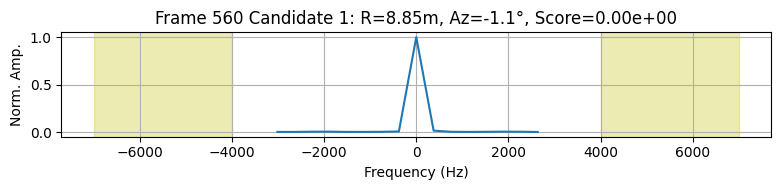

100%|██████████| 1/1 [00:00<00:00, 16.11it/s]


NameError: name 'vbins' is not defined

<Figure size 1200x600 with 0 Axes>

In [15]:

path_antenna_cfg = "../dataset/calib/single_chip/antenna_cfg.txt"
path_waveform_cfg = "../dataset/calib/single_chip/waveform_cfg.txt"
path_coulping_calib = "../dataset/calib/single_chip/coupling_calib.txt"

# Parameters extracted from .cfg file:
# profileCfg 0 77 110 4.0 56.0 0 0 70 1 256 5209 0 0 30
wf_start_frequency = 77e9          # 77 GHz
wf_idle_time = 110e-6              # 110 us
wf_adc_start_time = 4.0e-6         # 4.0 us
wf_ramp_end_time = 56.0e-6         # 56.0 us
wf_frequency_slope = 70e12         # 70 MHz/us
wf_num_adc_samples_per_chirp = 256 # 256 samples
wf_adc_sample_frequency = 5209e3   # 5209 ksps -> 5.209 MHz

# frameCfg 0 2 16 0 33.333 1 0
wf_num_chirps_per_frame = 16       # numLoops = 16

calibration_antenna_rxl, calibration_antenna_txl, fdesign = get_antenna_layout(path_antenna_cfg)
stime: float = wf_num_adc_samples_per_chirp / wf_adc_sample_frequency

chirp_time: float = wf_idle_time + wf_ramp_end_time 

# --- Configuration ---
start_frame = 560
num_frames = 1  # Number of frames to process
# base_path = "../dataset/2_24_2021_aspen_run11/single_chip/adc_samples/data/"

spectrogram_data = []
target_ranges = []

# print(f"Processing {num_frames} frames starting from {start_frame} to extract Micro-Doppler...")

# Ensure steering vector is available (from previous cells)
# num_vec, steering_vec = dsp.gen_steering_vec(AZ_RANGE, ANGLE_RES_AZ, AZ_CHANNELS, 2 * calibration_d)

for frame_idx in tqdm(range(start_frame, start_frame + num_frames)):
    # 1. Load Data
    # current_filepath = f"{base_path}frame_{frame_idx}.bin"
    # if not os.path.exists(current_filepath):
    #     print(f"Frame {frame_idx} not found. Stopping.")
    #     break
        
    raw = radar_messages[frame_idx].data
    
    # --- FIX: Correct Reshape for TDM-MIMO ---
    # Raw data stream order: Loops -> TX (Chirps) -> RX -> Samples -> IQ
    # 1. Reshape to match physical stream: (Loops=16, TX=3, RX=4, Samples=256, IQ=2)
    raw = np.reshape(raw, (16, 3, 4, 256, 2))
    
    # 2. Transpose to logical order: (TX, RX, Loops, Samples, IQ)
    raw = raw.transpose(1, 2, 0, 3, 4)
    
    I = np.float16(raw[:, :, :, :, 0])
    Q = np.float16(raw[:, :, :, :, 1])
    raw = I + 1j * Q
    
    # 2. Preprocess
    adc_samples = dc_remove(raw)
    _, _, Nc, Ns = get_fft_size(None, None, wf_num_chirps_per_frame, wf_num_adc_samples_per_chirp)
    rfft = np.fft.fft(adc_samples * np.blackman(wf_num_adc_samples_per_chirp).reshape(1, 1, 1, -1), Ns, -1)
    _rfft_full = pre_process(rfft, apply_padding=False)
    
    # 3. Find Target in Range-Azimuth Map
    # We use Bartlett for speed to find the strongest target
    _rfft = _rfft_full[0, :, :, :]
    _rfft = np.swapaxes(_rfft, 0, 1) # (Chirps, Azimuth, Range)
    BINS_PROCESSED_RANGE = _rfft.shape[2] # num_range_bins: sample number in one chirp, also the number of range bins
    AZ_CHANNELS = _rfft.shape[1]  # num_azimuth_channels: number of virtual azimuth channels
    range_azimuth = np.zeros((AZ_BINS, BINS_PROCESSED_RANGE))
    # using OpenRadar DSP library
    calibration_d = 0.5 * ((wf_start_frequency + (wf_frequency_slope * stime) / 2) / fdesign)
    num_vec, steering_vec = dsp.gen_steering_vec(AZ_RANGE, ANGLE_RES_AZ, AZ_CHANNELS,
                                                #  1)
                                                    2 * calibration_d) # 8 antennas in azimuth, 2 * calibration_d refers to the normalized antenna spacing (always *2 as th param)

    # Compute RA map (Bartlett)
    for i in range(BINS_PROCESSED_RANGE):
        # Using the previously defined steering_vec
        range_azimuth_multi = dsp.aoa_bartlett(steering_vec, _rfft[:, :, i], axis=1)
        range_azimuth[:, i] = np.abs(range_azimuth_multi.sum(0)).squeeze()
        
    # Mask near range to avoid self-interference/clutter
    range_azimuth[:, :CFAR_SKIP_RANGE_BIN_NEAR] = 0
    
    # --- Modified Target Selection Strategy ---
    # Find top N candidates based on RA map intensity
    num_candidates = 1
    flat_indices = np.argsort(range_azimuth.flatten())[-num_candidates:]
    # Process from strongest to weakest
    flat_indices = flat_indices[::-1]
    num_ant = 12
    best_score = -1.0
    selected_spectrum = None
    selected_range = 0.0
    
    # Frequency axis for Doppler (Hz)
    freqs = np.fft.fftshift(np.fft.fftfreq(Nc, chirp_time))
    
    # Iterate through candidates to find the one with Micro-Doppler in 4000-7000Hz
    for i, idx_cand in enumerate(flat_indices):
        vidx, ridx = np.unravel_index(idx_cand, range_azimuth.shape)
        
        cand_az = AZ_MESH[vidx]
        cand_range = rbins[ridx]
        
        # 4. Estimate Elevation & Extract Doppler (for this candidate)
        # Extract data for the target range bin
        elevation_raw = _rfft_full[:, :, :, ridx]
        
        # Construct Elevation Steering Vectors for the target Azimuth
        steering_vectors_ele = np.zeros((EL_BINS, num_ant), dtype='complex128')
        for kk in range(EL_BINS):
            ele_rad = EL_MESH[kk]
            A_steering = rdsp.steering_matrix(
                calibration_antenna_txl,
                calibration_antenna_rxl,
                cand_az,
                ele_rad,
                2 * calibration_d
            )
            steering_vectors_ele[kk, :] = A_steering.T
            
        # Form the virtual array matrix for elevation
        part1 = elevation_raw[0, 0:4, :]
        part2 = elevation_raw[1, 2:6, :]
        part3 = elevation_raw[0, 4:8, :]
        final_matrix = np.concatenate([part1, part2, part3], axis=0) # (12, 128)
        
        # Beamform in Elevation (Bartlett)
        ele_response = np.matmul(steering_vectors_ele.conj(), final_matrix) # (EL_BINS, 128)
        
        # Find best elevation angle
        ele_power = np.sum(np.abs(ele_response), axis=1)
        best_ele_idx = np.argmax(ele_power)
        
        # 5. Get Doppler Spectrum
        doppler_signal_time = ele_response[best_ele_idx, :]
        
        # Doppler FFT
        doppler_spectrum_complex = np.fft.fft(doppler_signal_time, Nc)
        doppler_spectrum_complex = np.fft.fftshift(doppler_spectrum_complex)
        doppler_spectrum_mag = np.abs(doppler_spectrum_complex)
        
        # Check Micro-Doppler Score (Max energy in 4000-7000Hz)
        mask = (np.abs(freqs) >= 4000) & (np.abs(freqs) <= 7000)
        if np.any(mask):
            score = np.max(doppler_spectrum_mag[mask])
        else:
            score = 0
            
        # Plot spectrum for the first frame candidates
        if frame_idx == start_frame:
            plt.figure(figsize=(8, 2))
            # Normalize
            if np.max(doppler_spectrum_mag) > 0:
                norm_mag = doppler_spectrum_mag / np.max(doppler_spectrum_mag)
            else:
                norm_mag = doppler_spectrum_mag
                
            plt.plot(freqs, norm_mag)
            plt.title(f"Frame {start_frame} Candidate {i+1}: R={cand_range:.2f}m, Az={np.rad2deg(cand_az):.1f}°, Score={score:.2e}")
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Norm. Amp.")
            plt.grid(True)
            # Highlight the band of interest
            plt.axvspan(4000, 7000, color='y', alpha=0.3)
            plt.axvspan(-7000, -4000, color='y', alpha=0.3)
            plt.tight_layout()
            plt.show()

        # Update best candidate (use > to prefer stronger RA peaks in case of ties, since we iterate strongest first)
        if score > best_score:
            best_score = score
            selected_spectrum = doppler_spectrum_mag
            selected_range = cand_range
        elif selected_spectrum is None:
            # Initialize with the first (strongest RA) candidate
            best_score = score
            selected_spectrum = doppler_spectrum_mag
            selected_range = cand_range

    spectrogram_data.append(selected_spectrum)
    target_ranges.append(selected_range)

spectrogram_data = np.array(spectrogram_data)

# --- Plotting ---
plt.figure(figsize=(12, 6))
plt.imshow(20*np.log10(spectrogram_data.T + 1e-9), aspect='auto', cmap='jet', 
           extent=[0, num_frames, vbins[0], vbins[-1]], origin='lower')
plt.colorbar(label='Magnitude (dB)')
plt.title(f'Micro-Doppler Spectrogram (Frames {start_frame}-{start_frame+num_frames})')
plt.xlabel('Frame Index')
plt.ylabel('Velocity (m/s)')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(target_ranges)
plt.title("Target Range over Frames")
plt.xlabel("Frame Index")
plt.ylabel("Range (m)")
plt.grid(True)
plt.show()